# Relative Momentum

Description

In [79]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import historic_sp500, STAR_DATE, END_DATE

### Importando os dados

In [80]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [81]:
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='01-01-2004'&@dataFinalCotacao='09-09-2024'&$format=json


In [82]:
relative_prices = pd.concat([ibov_prices, sp500_prices], keys=['IBOV', 'SP500 BRL'], join='inner', axis=1)
relative_prices = (relative_prices / relative_prices.iloc[0])

relative_prices

,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000
2004-01-05,1.048429,1.004152
2004-01-06,1.050390,1.001270
2004-01-07,1.038984,1.011210
2004-01-08,1.056672,1.011452
...,...,...
2024-08-30,6.059434,9.986100
2024-09-03,5.985877,9.716471
2024-09-04,6.064201,9.724193
2024-09-05,6.081622,9.641519


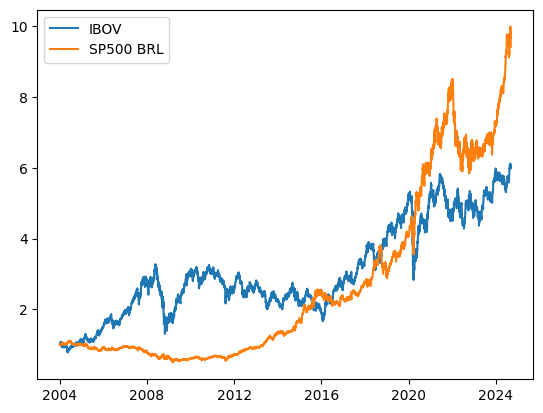

In [83]:

plt.plot(relative_prices)
plt.legend(relative_prices.columns)
plt.show()

In [84]:
ytd_returns = relative_prices.pct_change(periods=252).dropna()

ytd_returns

,IBOV,SP500 BRL
2005-01-18,0.073246,0.014527
2005-01-19,0.031404,0.002440
2005-01-20,0.001442,-0.001142
2005-01-21,0.021355,-0.025354
2005-01-24,0.020281,-0.036901
...,...,...
2024-08-30,0.182829,0.467453
2024-09-03,0.164147,0.430686
2024-09-04,0.189480,0.418531
2024-09-05,0.175161,0.422258


In [85]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,IBOV,SP500 BRL
2005-01-18,0.073246,0.014527
2005-02-01,0.051694,-0.023893
2005-03-01,0.250733,-0.058704
2005-04-01,0.238791,-0.033230
2005-05-02,0.107252,-0.105415
...,...,...
2024-05-02,0.199083,0.263419
2024-06-03,0.114855,0.343807
2024-07-01,0.046108,0.433863
2024-08-01,0.083733,0.408701


In [86]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['SP500 BRL']),
]

cases = ['IBOV', 'SP500 BRL']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,IBOV,SP500 BRL,Investment
2005-01-18,0.073246,0.014527,IBOV
2005-01-19,0.031404,0.002440,IBOV
2005-01-20,0.001442,-0.001142,IBOV
2005-01-21,0.021355,-0.025354,IBOV
2005-01-24,0.020281,-0.036901,IBOV
...,...,...,...
2024-08-30,0.182829,0.467453,SP500 BRL
2024-09-03,0.164147,0.430686,SP500 BRL
2024-09-04,0.189480,0.418531,SP500 BRL
2024-09-05,0.175161,0.422258,SP500 BRL


In [87]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
SP500 BRL    0.54
IBOV         0.46
Name: proportion, dtype: float64

In [88]:
relative_momentum = relative_prices.pct_change().join(ytd_returns[['Investment']], how='right')

relative_momentum

,IBOV,SP500 BRL,Investment
2005-01-18,-0.033502,0.012099,IBOV
2005-01-19,0.007555,-0.007811,IBOV
2005-01-20,-0.027234,-0.006433,IBOV
2005-01-21,0.008810,-0.014554,IBOV
2005-01-24,0.015954,-0.011611,IBOV
...,...,...,...
2024-08-30,-0.000272,0.013749,SP500 BRL
2024-09-03,-0.012139,-0.027000,SP500 BRL
2024-09-04,0.013085,0.000795,SP500 BRL
2024-09-05,0.002873,-0.008502,SP500 BRL


In [89]:
relative_momentum['Relative Momentum'] = relative_momentum.apply(lambda row: row[row['Investment']], axis=1)
relative_momentum = relative_momentum.drop(columns=['Investment'])

relative_momentum

,IBOV,SP500 BRL,Relative Momentum
2005-01-18,-0.033502,0.012099,-0.033502
2005-01-19,0.007555,-0.007811,0.007555
2005-01-20,-0.027234,-0.006433,-0.027234
2005-01-21,0.008810,-0.014554,0.008810
2005-01-24,0.015954,-0.011611,0.015954
...,...,...,...
2024-08-30,-0.000272,0.013749,0.013749
2024-09-03,-0.012139,-0.027000,-0.027000
2024-09-04,0.013085,0.000795,0.000795
2024-09-05,0.002873,-0.008502,-0.008502


In [90]:
relative_momentum_eval = (1 + relative_momentum).cumprod()
relative_momentum_eval = (relative_momentum_eval / relative_momentum_eval.iloc[0]) - 1

relative_momentum_eval

,IBOV,SP500 BRL,Relative Momentum
2005-01-18,0.000000,0.000000,0.000000
2005-01-19,0.007555,-0.007811,0.007555
2005-01-20,-0.019885,-0.014194,-0.019885
2005-01-21,-0.011250,-0.028541,-0.011250
2005-01-24,0.004525,-0.039820,0.004525
...,...,...,...
2024-08-30,4.645896,8.843112,12.986009
2024-09-03,4.577359,8.577344,12.608381
2024-09-04,4.650338,8.584955,12.619196
2024-09-05,4.666570,8.503465,12.503407


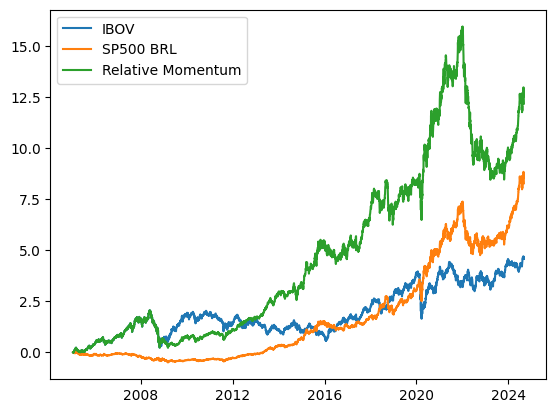

In [91]:
plt.plot(relative_momentum_eval)
plt.legend(relative_momentum_eval.columns)
plt.show()

In [92]:
relative_momentum_eval = relative_momentum_eval + 1
relative_momentum_eval.index = pd.to_datetime(relative_momentum_eval.index)

series_start = relative_momentum_eval.index.min()
series_end = relative_momentum_eval.index.max()

years = (series_end - series_start).days / 365.25

avg_return = (relative_momentum_eval.iloc[-1] / (relative_momentum_eval.iloc[0])) ** (1 / years) - 1
avg_vol = relative_momentum.std() * (252 ** 0.5)

In [93]:
total_results = pd.concat([avg_return, avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)

total_results


,Avg Return,Avg Vol
IBOV,0.091578,0.268606
SP500 BRL,0.120173,0.212045
Relative Momentum,0.140396,0.243624


In [96]:
total_results['Sharpe Ratio'] = (total_results['Avg Return'] - 0.1050) / total_results['Avg Vol']

total_results

,Avg Return,Avg Vol,Sharpe Ratio
IBOV,0.091578,0.268606,-0.049968
SP500 BRL,0.120173,0.212045,0.071557
Relative Momentum,0.140396,0.243624,0.145291
